In [1]:
%load_ext autoreload
%autoreload 2

from multiprocessing import cpu_count
import os
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning.loggers.neptune import NeptuneLogger
import ray
import seaborn
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from nemo.data.dataloader import TrialAvgNeuralDataset
from nemo.model.analysis.feature_visualization import write_simple_cell_strfs
from nemo.model.models import ElasticNet
from nemo.model.layers import Identity
from nemo.model.utils import tune_model

In [2]:
# hparam tuning
alphas = ray.tune.uniform(0.0, 1.0)
lambdas = ray.tune.loguniform(1e-4, 1e4)
lrs = ray.tune.loguniform(1e-5, 1e-1)
batch_sizes = 128
loss_fns = ray.tune.choice([
    torch.nn.MSELoss(reduction = 'sum'),
    torch.nn.PoissonNLLLoss(reduction = 'sum')
])
optims = torch.optim.SGD
act_fns = ray.tune.choice([Identity(), torch.nn.Sigmoid()])
n_tune_samples = 100

# DataSet Args
n_frames = 9
stim_height = 40 
stim_width = 64
train_stim = ['natural_movie_three']
val_stim = ['natural_movie_two']
test_stim = ['natural_movie_one']

# DataLoader Args
test_batch_size = 300
n_workers = 8
val_frac = 0.20

# PLTrainer Args
n_gpus = 1
max_steps = 10000
n_cpu_tune = 6
patience = 5
tol = 1e-1

## "Population" Model

In [3]:
dset = TrialAvgNeuralDataset(
    data_dir = '../../data/AIBO/VISp/L4/Exc/ExtractedData',
    stimuli = train_stim + val_stim + test_stim,
    stim_height = stim_height,
    stim_width = stim_width,
    n_frames = n_frames,
    smooth = True,
    col_transform = lambda x: x.subtract(x.min()).divide(x.max() - x.min())
)

INFO -- 04/03/2021 10:34:49 AM -- Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

KeyboardInterrupt



In [4]:
dset.data

,stimulus,frame,517397343_511498742,517397347_511498742,517397357_511498742,517397441_511498742,517397464_511498742,517397474_511498742,517397528_511498742,517397564_511498742,...,738948440_712178509,738948535_712178509,738948566_712178509,738948605_712178509,738948646_712178509,738948685_712178509,738948725_712178509,738948770_712178509,738948842_712178509,738948929_712178509
0,natural_movie_one,0.0,0.237793,0.218750,0.117981,0.161011,0.139160,0.182007,0.386475,0.068054,...,0.110962,0.166504,0.285889,0.247681,0.224731,0.235840,0.084229,0.170898,0.101501,0.131348
1,natural_movie_one,1.0,0.301514,0.197876,0.110779,0.234375,0.103394,0.194946,0.388428,0.058777,...,0.143677,0.215454,0.310791,0.237305,0.258057,0.257324,0.114075,0.142700,0.107788,0.196899
2,natural_movie_one,2.0,0.255127,0.171509,0.111023,0.210205,0.156616,0.158203,0.364014,0.061157,...,0.125244,0.163208,0.277832,0.221313,0.204468,0.244873,0.069885,0.144897,0.097900,0.147095
3,natural_movie_one,3.0,0.296875,0.217163,0.136108,0.286133,0.158447,0.225464,0.331543,0.061920,...,0.136963,0.256836,0.283203,0.200317,0.202148,0.302246,0.102661,0.134888,0.080261,0.136597
4,natural_movie_one,4.0,0.278320,0.255615,0.150391,0.255615,0.136230,0.190918,0.286133,0.067139,...,0.127197,0.203003,0.325439,0.210205,0.237305,0.282471,0.118713,0.149048,0.099426,0.208984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,natural_movie_two,895.0,0.245117,0.336670,0.139893,0.250244,0.196899,0.242554,0.122070,0.055298,...,0.130737,0.153320,0.377441,0.339844,0.287842,0.346680,0.144043,0.189575,0.219360,0.168701
5396,natural_movie_two,896.0,0.265869,0.322266,0.124939,0.232910,0.167358,0.197021,0.156982,0.048065,...,0.095764,0.105530,0.326904,0.145264,0.224243,0.326416,0.134888,0.146606,0.156860,0.161133
5397,natural_movie_two,897.0,0.182739,0.337891,0.134766,0.276611,0.167603,0.180908,0.140625,0.057068,...,0.095093,0.217285,0.454346,0.201538,0.299072,0.190918,0.129150,0.208984,0.131958,0.062561
5398,natural_movie_two,898.0,0.271973,0.301758,0.141724,0.223145,0.203247,0.141235,0.137207,0.059967,...,0.054596,0.198608,0.334961,0.226562,0.220947,0.395020,0.149780,0.168945,0.132324,0.153809


In [5]:
dset.cc_max.max()

2.477

Text(96.0, 0.5, 'Neuron')

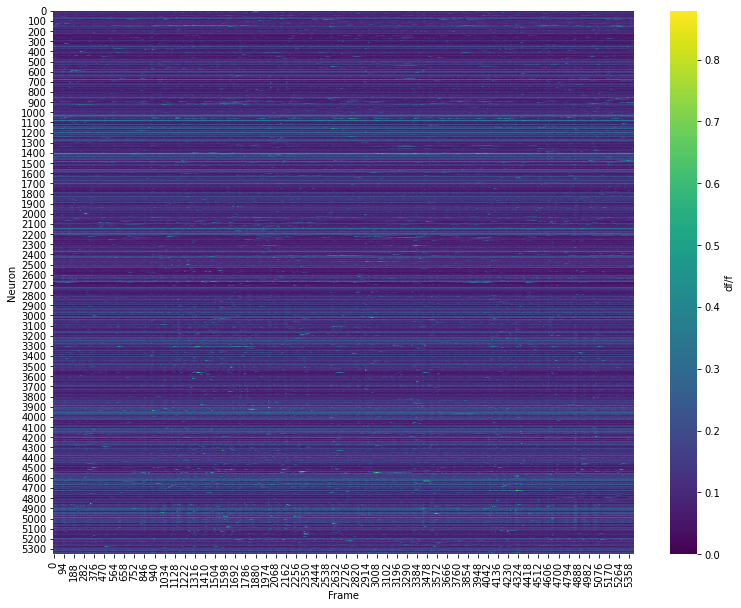

In [6]:
fig = plt.figure(figsize = (13, 10))
seaborn.heatmap(
    data = dset.data.set_index(['stimulus', 'frame']).to_numpy().transpose(),
    cmap = 'viridis',
    vmin = 0.0,
    cbar_kws = {'label': 'df/f'}
)
plt.xlabel('Frame')
plt.ylabel('Neuron')

In [6]:
train_inds = dset.data.index[dset.data.stimulus.isin(train_stim)].to_list()
val_inds = dset.data.index[dset.data.stimulus.isin(val_stim)].to_list()
test_inds = dset.data.index[dset.data.stimulus.isin(test_stim)].to_list()
print(len(train_inds), len(val_inds), len(test_inds), len(set(train_inds) & set(test_inds) & set(val_inds)))

3600 900 900 0


In [7]:
test_dl = DataLoader(
    dset,
    batch_size = test_batch_size,
    num_workers = n_workers,
    sampler = SequentialSampler(test_inds),
    drop_last = False
)

In [7]:
config = {
    'lr': lrs,
    'alpha': alphas,
    'lambd': lambdas,
    'act_fn': act_fns,
    'loss_fn': loss_fns,
    'optim': optims,
    'norm_fn': ray.tune.choice([
        torch.nn.BatchNorm1d(len(dset.cell_ids)),
        torch.nn.LayerNorm(len(dset.cell_ids))
    ]),
    'batch_size': batch_sizes,
    'n_neurons': len(dset.cell_ids),
    'in_h': stim_height,
    'in_w': stim_width,
    'n_frames': n_frames,
    'patience': patience,
    'tol': tol
}

In [8]:
analysis = ray.tune.run(
    ray.tune.with_parameters(
        tune_model,
        ptl_model = ElasticNet,
        dset = dset,
        train_inds = train_inds,
        val_inds = val_inds,
        n_workers = n_workers,
        tune_metrics = {'loss': 'val_loss'},
        mode = 'tune',
        gpus = n_gpus,
        max_steps = max_steps,
        check_val_every_n_epoch = 1,
        progress_bar_refresh_rate = 0,
        weights_summary = None
    ),
    config = config,
    num_samples = n_tune_samples,
    resources_per_trial = {'cpu': n_cpu_tune, 'gpu': n_gpus},
    verbose = 0, 
    metric = 'loss',
    mode = 'min',
    local_dir = './population_hp_tune_results'
)

INFO -- 04/02/2021 12:00:49 PM -- Initializing Ray automatically.For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run`.
2021-04-02 12:00:50,141	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
2021-04-02 12:00:51,679	WARNING function_runner.py:541 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
(pid=27564) GPU available: True, used: True
(pid=27564) TPU available: None, using: 0 TPU cores
(pid=27564) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=27561) GPU available: True, used: True
(pid=27561) TPU available: None, using: 0 TPU cores
(pid=27561) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
2021-04-02 12:01:30,380	WARNING util.py:152 -- The `fetch_result` operation took 1.572 s, which may be a performance bottleneck.
2021-04-02 12:01:30,385	WARNING util.py:152 

In [9]:
analysis.best_config

{'lr': 0.0002702409149245896,
 'alpha': 0.424661790921947,
 'lambd': 0.00041519959877323113,
 'act_fn': Identity(),
 'loss_fn': MSELoss(),
 'optim': torch.optim.sgd.SGD,
 'norm_fn': BatchNorm1d(5353, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 'batch_size': 256,
 'n_neurons': 5353,
 'in_h': 40,
 'in_w': 64,
 'n_frames': 9,
 'patience': 5,
 'tol': 0.1}

In [10]:
result_df = analysis.results_df

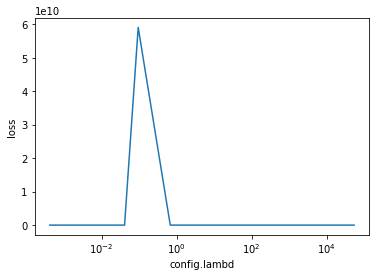

In [11]:
seaborn.lineplot(
    data = result_df,
    x = 'config.lambd',
    y = 'loss'
)
plt.xscale('log')
plt.show()

<AxesSubplot:xlabel='config.lambd', ylabel='config.alpha'>

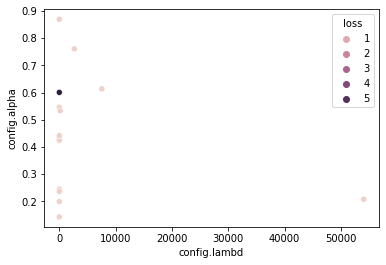

In [12]:
seaborn.scatterplot(
    data = result_df,
    x = 'config.lambd',
    y = 'config.alpha',
    hue = 'loss'
)

In [13]:
trainer = tune_model(
    config = analysis.best_config,
    ptl_model = ElasticNet,
    dset = dset,
    train_inds = train_inds + val_inds,
    n_workers = cpu_count() - 4,
    n_val = int(0.1 * len(train_inds + val_inds)),
    mode = 'train',
    gpus = n_gpus,
    max_steps = max_steps,
    check_val_every_n_epoch = 1,
    progress_bar_refresh_rate = 50,
    logger = NeptuneLogger(
        api_key = os.environ['NEPTUNE_API_TOKEN'],
        project_name = 'mteti/neural-encoding-elasticnet',
        experiment_name = 'population_model',
        params = {
            k: v.real if k in ['alpha', 'lr', 'lambd'] else v 
            for k, v in analysis.best_config.items()
        }
    )
)

NeptuneLogger will work in online mode
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


https://ui.neptune.ai/mteti/neural-encoding-elasticnet/e/ELASTICNET-27



  | Name    | Type        | Params
----------------------------------------
0 | loss_fn | MSELoss     | 0     
1 | act_fn  | Identity    | 0     
2 | norm_fn | BatchNorm1d | 10.7 K
3 | strf    | Linear      | 123 M 
----------------------------------------
123 M     Trainable params
0         Non-trainable params
123 M     Total params
493.397   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]              
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 16/16 [00:11<00:00,  1.45it/s, loss=3.47e+05, v_num=T-27]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s, loss=1.36e+04, v_num=T-27]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 16/16 [00:11<00:00,  1.45it/s, loss=772, v_num=T-27]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s, loss=622, v_num=T-27]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 16/16 [00:10<00:00,  1.48it/s, loss=610, v_num=T-27]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 16/16 [00:11<00:00,  1.41it/s, loss=602, v_num=T-27]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 16/16 [00:11<00:00,  1.37it/s, loss=595, v_num=T-27]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 16/16 [00:11<00:00,  1.44it/s, loss=585, v_num=T-27]
Validating: 0it [00:00, ?it/s]
Epoch 9:

In [14]:
trainer.test(trainer.get_model(), test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 284.868896484375}
--------------------------------------------------------------------------------


[{'test_loss': 284.868896484375}]

In [15]:
best_model = trainer.get_model()

In [16]:
best_weights = best_model.strf.weight.detach().cpu().numpy()
best_weights = best_weights.reshape([-1, n_frames, stim_height, stim_width])
best_weights = [best_weights[:, frame_num, ...][:, None, None, None] for frame_num in range(n_frames)]
print(best_weights[0].shape)
write_simple_cell_strfs(best_weights, './population_mse_loss_no_bias_one_neuron')

(5353, 1, 1, 1, 40, 64)


In [17]:
preds = np.zeros([len(test_inds), len(dset.cell_ids)])
true = preds.copy()

for batch_num, batch in enumerate(test_dl):
    y = batch[1][-1]
    batch = ([x.cuda() for x in batch[0]], [y.cuda() for y in batch[1]])
    y_hat = best_model.predict_step(batch, batch_num)
    preds[batch_num * test_batch_size: (batch_num + 1) * test_batch_size] = y_hat.detach().cpu().numpy()
    true[batch_num * test_batch_size: (batch_num + 1) * test_batch_size] = y.numpy()

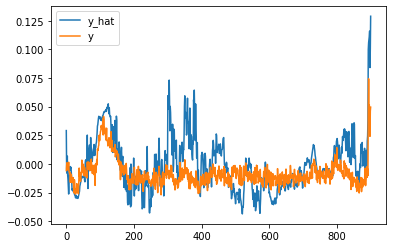

In [20]:
plt.plot(preds[:, 20], label = 'y_hat')
plt.plot(true[:, 20], label = 'y')
plt.legend()
plt.show()